In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import pickle
import scipy.io
import idx2numpy
import random
from matplotlib import pyplot as plt

In [2]:
train_images = idx2numpy.convert_from_file('train-images-idx3-ubyte')
train_label = idx2numpy.convert_from_file('train-labels-idx1-ubyte')

test_images = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
test_label = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')

In [3]:
train = {}
test = {}

train['X'] = train_images
train['y'] = train_label

test['X'] = test_images
test['y'] = test_label

In [4]:
print('train : ', train_images.shape, train_label.shape)
print('test : ', test_images.shape, test_label.shape)

train :  (60000, 28, 28) (60000,)
test :  (10000, 28, 28) (10000,)


In [5]:
# Inserts 'seq' sequence's elements at random places inside the list 'lst'

def random_insert_seq(lst, seq):
    insert_locations = random.sample(xrange(len(lst) + len(seq)), len(seq))
    inserts = dict(zip(insert_locations, seq))
    input = iter(lst)
    lst[:] = [inserts[pos] if pos in inserts else next(input)
        for pos in xrange(len(lst) + len(seq))]

In [6]:
def randomize_inputs(X_training, Y_labelling, no_of_white_images):
    w = X_training.shape[1]
    n = X_training.shape[0]
    k = no_of_white_images
    print ('w : ', w, ' n : ', n, ' k : ', k)
    
    Y_expand_label = np.zeros((n, 1, w), dtype=np.int)
    for i in range(0,n):
        Y_expand_label[i,:,:] = Y_labelling[i]
        
    data_expand = np.concatenate((X_training ,Y_expand_label), axis=1)
    
    assert (data_expand.shape[1] == w + 1)
    
    # 'white_image_mat' and 'white_image_label' prepare 'k' white images and their label
    white_image_mat = np.zeros((k, w, w))
    white_image_label = np.full((k, 1, w), None)
    
    white_images_big = np.concatenate((white_image_mat ,white_image_label), axis=1)
    
    assert (white_images_big.shape[1] == w + 1)
    
    data_big = np.concatenate((data_expand ,white_images_big))
    
    assert (data_big.shape[0] == n + k and data_big.shape[1] == w + 1 and data_big.shape[2] == w)
    
    np.random.shuffle(data_big)
    assert (data_big.shape[0] == n + k and data_big.shape[1] == w + 1 and data_big.shape[2] == w)
    
    count = 0
    list_of_outputs = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]
    for i in range(0, n + k):
        if data_big[i][28][0] not in list_of_outputs :
            count += 1

    assert (count == k)
    
    Y_out = data_big[:,w][:,0]
    X_out = np.delete(data_big, w, axis=1)
    
    return X_out, Y_out

In [7]:
# def multiple_img_dataset_generator(X_dataset, Y_dataset, no_of_iamges_to_combine, length_of_new_dataset) :
#     assert (X_dataset.shape[0] == Y_dataset.shape[0])
    
#     n = X_dataset.shape[0]
#     w = X_dataset.shape[1]        # Assuming image have same width and height
#     c = no_of_iamges_to_combine
#     k = length_of_new_dataset
    
#     rand_list = random_list_length_generator(0, n, c, k)
    
#     # To retain Zeros before the number, like 005 or 0670,
#     # Y_train_multi is made to store objects of type 'String'
    
#     X_new = np.zeros((k, w, c*w))
#     # Y_new = np.zeros((k), dtype='|S6')
#     Y_new = np.zeros((k), dtype=np.int)
    
#     for i in range(k):
#         rand_index = rand_list[i]

#         images_index = []
#         label_index = []
#         for r in rand_index :
#             images_index.append(X_dataset[r])
#             label_index.append(Y_dataset[r])

#         stacked_images = stack_matrices_horizontally(images_index)
#         stacked_labels = stack_labels_horizontally(label_index)

#         X_new[i] = stacked_images
#         Y_new[i] = stacked_labels
    
#     print('Matrix Conversion Successful')
    
#     return X_new, Y_new

In [8]:
# def stack_matrices_horizontally(list_of_matrices):
#     return np.hstack((list_of_matrices))


# def stack_labels_horizontally(list_of_outputs):
#     possible_list = [0,1,2,3,4,5,6,7,8,9]
    
#     outs = []
#     for i in list_of_outputs :
#         if i in possible_list :
#             outs.append(int(i))
    
#     l = len(outs)
#     stra = ''
#     for j in outs:
#         a = str(j)
#         stra += a
        
#     if len(stra) != 0:
#         final_out = (stra)
#         return final_out
#     else :
#         return (10)

In [9]:
def random_list_length_generator(start_pt, end_pt, part_length, list_length) :
    random_list = []
    for i in range(list_length):
        random_list.append(random.sample(range(start_pt, end_pt), part_length))
        
    return random_list

In [10]:
def stack_matrices_horizontally(list_of_matrices, width_of_image):
    w_mat = []
    non_w_mat = []
    
    white_matrix = np.zeros((width_of_image, width_of_image))
    
    for mat in list_of_matrices :
        assert white_matrix.shape == mat.shape
        if ((mat == white_matrix).all()) :
            w_mat.append(mat)
        else :
            non_w_mat.append(mat)
    
    f_list = non_w_mat + w_mat
        
    return np.hstack((f_list))


def stack_labels_horizontally(list_of_outputs, no_of_images_to_combine):
    possible_list = [0,1,2,3,4,5,6,7,8,9]
    
    outs = []
    for i in list_of_outputs :
        if i in possible_list :
            outs.append(int(i))
    
    out_l = len(outs)
    
    no_of_blanks = no_of_images_to_combine - out_l
    
    blank_list = []
    for i in range(no_of_blanks) :
        blank_list.append(10)
    
    f_list = [out_l] + outs + blank_list
    
    return f_list

In [11]:
def multiple_img_dataset_generator(X_dataset, Y_dataset, no_of_iamges_to_combine, length_of_new_dataset) :
    assert (X_dataset.shape[0] == Y_dataset.shape[0])
    
    n = X_dataset.shape[0]
    w = X_dataset.shape[1]        # Assuming image have same width and height
    c = no_of_iamges_to_combine
    k = length_of_new_dataset
    
    rand_list = random_list_length_generator(0, n, c, k)
        
    # To retain Zeros before the number, like 005 or 0670,
    # Y_train_multi is made to store objects of type 'String'
    
    X_new = np.zeros((k, w, c*w))
    # Y_new = np.zeros((k), dtype='|S6')
    Y_new = np.zeros((k, c+1), dtype=np.int)
    
    for i in range(k):
        # Get 5 random indexes
        rand_index = rand_list[i]

        images_index = []
        label_index = []
        
        for r in rand_index :
            images_index.append(X_dataset[r])
            label_index.append(Y_dataset[r])

        stacked_images = stack_matrices_horizontally(images_index, w)
        stacked_labels = stack_labels_horizontally(label_index, c)

        X_new[i] = stacked_images
        Y_new[i] = stacked_labels
    
    print('Matrix Conversion Successful')
    
    return X_new, Y_new

In [12]:
def plot_img(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [13]:
X_test_new, Y_test_new = randomize_inputs(test_images, test_label, 2500)

w :  28  n :  10000  k :  2500


//anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((2500, 1, 28), None) will return an array of dtype('O')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [14]:
X_test_multi, Y_test_multi = multiple_img_dataset_generator(X_test_new, Y_test_new, 5, 10000)

Matrix Conversion Successful


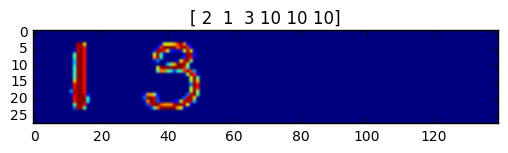

In [15]:
plot_img(X_test_multi[120], Y_test_multi[120])

In [16]:
X_train_new, Y_train_new = randomize_inputs(train_images, train_label, 20000)
X_train_multi, Y_train_multi = multiple_img_dataset_generator(X_train_new, Y_train_new, 5, 80000)

w :  28  n :  60000  k :  20000


//anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((20000, 1, 28), None) will return an array of dtype('O')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


Matrix Conversion Successful


In [17]:
print (X_train_multi.shape, Y_train_multi.shape)
print (X_test_multi.shape, Y_test_multi.shape)

(80000, 28, 140) (80000, 6)
(10000, 28, 140) (10000, 6)


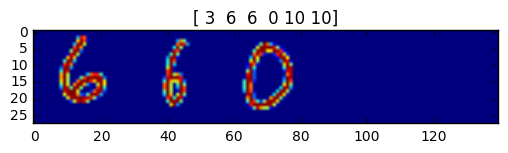

In [18]:
plot_img(X_train_multi[105], Y_train_multi[105])

In [19]:
X_train_multi = X_train_multi[:,:,:,np.newaxis]
X_test_multi = X_test_multi[:,:,:,np.newaxis]

In [20]:
print (X_train_multi.shape, Y_train_multi.shape)
print (X_test_multi.shape, Y_test_multi.shape)

(80000, 28, 140, 1) (80000, 6)
(10000, 28, 140, 1) (10000, 6)


In [21]:
train_multi = {}
test_multi = {}

train_multi['X'] = X_train_multi
train_multi['y'] = Y_train_multi

test_multi['X'] = X_test_multi
test_multi['y'] = Y_test_multi

In [22]:
scipy.io.savemat('mnist_multi_train_28x140.mat', train_multi)
scipy.io.savemat('mnist_multi_test_28x140.mat', test_multi)

In [ ]:
########## Converting notMNIST data in this format  ###########

In [24]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset_notM = save['train_dataset']
    train_labels_notM = save['train_labels']
    valid_dataset_notM = save['valid_dataset']
    valid_labels_notM = save['valid_labels']
    test_dataset_notM = save['test_dataset']
    test_labels_notM = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset_notM.shape, train_labels_notM.shape)
    print('Validation set', valid_dataset_notM.shape, valid_labels_notM.shape)
    print('Test set', test_dataset_notM.shape, test_labels_notM.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [26]:
X_train_notM, Y_train_notM = randomize_inputs(train_dataset_notM, train_labels_notM, 20000)
X_test_notM, Y_test_notM = randomize_inputs(test_dataset_notM, test_labels_notM, 1000)
X_valid_notM, Y_valid_notM = randomize_inputs(valid_dataset_notM, valid_labels_notM, 1000)

w :  28  n :  200000  k :  20000
w :  28  n :  10000  k :  1000


//anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((1000, 1, 28), None) will return an array of dtype('O')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


w :  28  n :  10000  k :  1000


In [28]:
X_train_notM, Y_train_notM = multiple_img_dataset_generator(X_train_notM, Y_train_notM, 5, 150000)
X_test_notM, Y_test_notM = multiple_img_dataset_generator(X_test_notM, Y_test_notM, 5, 12000)
X_valid_notM, Y_valid_notM = multiple_img_dataset_generator(X_valid_notM, Y_valid_notM, 5, 12000)

KeyboardInterrupt: 

In [ ]:
X_train_notM = X_train_notM[:,:,:,np.newaxis]
X_test_notM = X_test_notM[:,:,:,np.newaxis]
X_valid_notM = X_valid_notM[:,:,:,np.newaxis]

In [ ]:
print('Training set', X_train_notM.shape, Y_train_notM.shape)
    print('Validation set', X_valid_notM.shape, Y_test_notM.shape)
    print('Test set', X_test_notM.shape, Y_test_notM.shape)

In [ ]:
scipy.io.savemat('notMNIST_multi_train_28x140.mat', train_multi)
scipy.io.savemat('notMNIST_multi_test_28x140.mat', test_multi)